# Seq2Seq Machine Translation with Attention

## 1. Preprocessing

Dataset link: https://www.statmt.org/wmt13/training-parallel-europarl-v7.tgz

In [31]:
%load_ext autoreload
%autoreload 2

In [1]:
# Check the size of both datasets
with open("./data/unprocessed/europarl-v7.de-en.de") as file:
    ger = [line.rstrip() for line in file]
with open("./data/unprocessed/europarl-v7.de-en.en") as file:
    eng = [line.rstrip() for line in file]

print(len(eng))
print(len(ger))

1920209
1920209


In [3]:
# Create small trainig set to test computations 
with open("./data/processed/train.csv", "r") as file:
        with open("./data/processed/train_mini.csv", "w") as new_file:
            i = 0
            for line in file:
                if i < 50000:
                    new_file.write(line)
                    
                i+=1
print("File successfully created.")

File successfully created.


In [5]:
# Load spacy data
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [6]:
from seq2seq_attention.preprocess import get_parallel_csv

# Take ">" as seperator since it is not included in the text - unique to seperate eng-ger pairs. 
# Remove any ">" from text pairs.
get_parallel_csv(path_1="./data/unprocessed/europarl-v7.de-en.de", path_2="./data/unprocessed/europarl-v7.de-en.en", new_file_path="./data/processed/en_ger_full.csv", delimiter=">")

File successfully created.
11289 lines were removed.


In [40]:
# Remove sentences with lower number of words
from seq2seq_attention.preprocess import remove_sentences
remove_sentences(data_dir="./data/processed/en_ger_full.csv", min_length=4, max_length=30, delimiter=">", new_file_path="./data/processed/en_ger_full_removed_sent_len.csv")

File successfully created.
824619 sentence-pairs were removed.


In [41]:
from seq2seq_attention.preprocess import train_test_split
train_test_split(file_path="./data/processed/en_ger_full_removed_sent_len.csv", sep=">", random_seed=118, dir="./data/processed")

All files successfully created.


In [43]:
# Check files
import pandas as pd
train = pd.read_csv("./data/processed/train.csv", header=None, sep=">", names=["ger", "eng"])
val = pd.read_csv("./data/processed/val.csv", header=None, sep=">", names=["ger", "eng"])
test = pd.read_csv("./data/processed/test.csv", header=None,sep=">", names=["ger", "eng"])

In [44]:
train_len = len(train)
val_len = len(val)
test_len = len(test)
print(f"Train: {train_len}, Val: {val_len}, Test: {test_len}")
print(f"Total: {train_len+val_len+test_len}")
print(f"Total + Removed: {train_len+val_len+test_len+11289+824619}")

Train: 867441, Val: 108430, Test: 108430
Total: 1084301
Total + Removed: 1920209


In [11]:
train.head()

,ger,eng
0,Indessen ist weder bei Bulgarien noch bei Rumä...,Neither Bulgaria nor Romania’s accession proc...
1,Seit Amsterdam stehen drei Begriffe im Mittelp...,"Since Amsterdam, three terms have taken centr..."
2,Um die Kyoto-Ziele zu erfüllen und die Umwelt ...,In order to meet the Kyoto objectives and to ...
3,Das irische Volk hat die spezifische Version d...,The Irish people rejected the particular vers...
4,Es gab eindeutige Hinweise auf organisierte An...,There were clear signs of organised attacks o...


In [12]:
val.head()

,ger,eng
0,Wir können die Änderungsanträge 49 und 50 nich...,"We cannot accept Amendments Nos 49 and 50, wh..."
1,"Daher schlage ich vor, dass wir uns unter hohe...","That is why, while keenly appreciating the ri..."
2,"Deshalb sollten wir versuchen, diesem anderen ...","It is to this other Iran, then, that we shoul..."
3,"Es besteht kein Mangel an Kreativität, was den...",There is no lack of creativity when it comes ...
4,"Ich bitte dringend darum, den Themen mehr Aufm...",I would urge that more attention be paid to i...


In [13]:
test.head()

,ger,eng
0,Sie haben Regulierungsinstrumente für die Prod...,They have destroyed regulatory instruments fo...
1,Keine andere Meinung zählt.,Nobody else has a say.
2,"Deshalb müssen wir dagegen protestieren, dass ...",That is why we must protest against the fact ...
3,Die Aussprache ist hiermit geschlossen.,That concludes the debate.
4,"Wie meine Vorredner und Vorrednerinnen, Herr K...","Like the previous speakers, Commissioner, I t..."


## 2. Initialize Dataloaders

In [1]:
from seq2seq_attention.build_dataloaders import build_fields, build_bucket_iterator, get_datasets, build_vocab
BATCH_SIZE = 100
DEVICE = "cpu"

src_field, trg_field = build_fields()
train_set, val_set, test_set = get_datasets(train_path="./data/processed/train.csv", 
                                            val_path="./data/processed/val.csv", 
                                            test_path="./data/processed/test.csv", 
                                            src_field=src_field, 
                                            trg_field=trg_field)
build_vocab(src_field=src_field, trg_field=trg_field, train_set=train_set, min_freq=2, max_vocab_size=32000)

In [2]:
# Check vocabulary 
len(src_field.vocab)

32004

In [15]:
train_loader = build_bucket_iterator(dataset=train_set, batch_size=BATCH_SIZE, device=DEVICE)
val_loader = build_bucket_iterator(dataset=val_set, batch_size=BATCH_SIZE, device=DEVICE)
test_loader = build_bucket_iterator(dataset=test_set, batch_size=BATCH_SIZE, device=DEVICE)

In [16]:
# Retrieve sample batch
iterator = iter(train_loader)

In [17]:
example = next(iterator)
src_batch = example.src
trg_batch = example.trg
print(src_batch[0].shape, src_batch[1].shape)
print(trg_batch[0].shape, trg_batch[1].shape)

torch.Size([100, 6]) torch.Size([100])
torch.Size([10]) torch.Size([10])


In [18]:
print(src_batch[1])

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6])


In [19]:
print(trg_batch[1])

tensor([   2,   17,   13, 3232,    6,    3,    1,    1,    1,    1])


In [21]:
# itos is list of token strings with their idx 
for j in range(5):
    src = ""
    for i in src_batch[0][j]:
       src = " ".join([src,  src_field.vocab.itos[i]])
    print(src)
    trg = ""
    for i in trg_batch[j]:
        trg = " ".join([trg, trg_field.vocab.itos[i]])
    print(trg)
    print()
# The second element in the tuple is the real length that we pass to the packed_seq!

 <sos> gibt es einwände ? <eos>
 <sos> are there any comments ? <eos> <pad> <pad> <pad>

 <sos> das ist absurd . <eos>
 <sos> this is absurd . <eos> <pad> <pad> <pad> <pad>

 <sos> - vor der abstimmung <eos>
 <sos> - before the vote : <eos> <pad> <pad> <pad>

 <sos> <unk> ( fortsetzung ) <eos>
 <sos> alpine transit ( continuation ) <eos> <pad> <pad> <pad>

 <sos> das ist bedauernswert . <eos>
 <sos> that is regrettable . <eos> <pad> <pad> <pad> <pad>



## 3. Evaluation

In [188]:
val_loss = pd.read_csv("./experiments/val_loss_clean")
val_loss.head()

,Uniform-Attention,Exp_1,Exp_2,Exp_3,Exp_4
0,5.761950,6.052050,5.630557,5.249187,5.804745
1,5.515731,6.066290,5.261449,4.921232,5.687445
2,5.449075,5.755107,5.248887,4.823582,5.626943
3,5.482353,5.717217,5.313386,4.945448,5.667874
4,5.204252,5.610363,5.084721,4.788809,5.217316


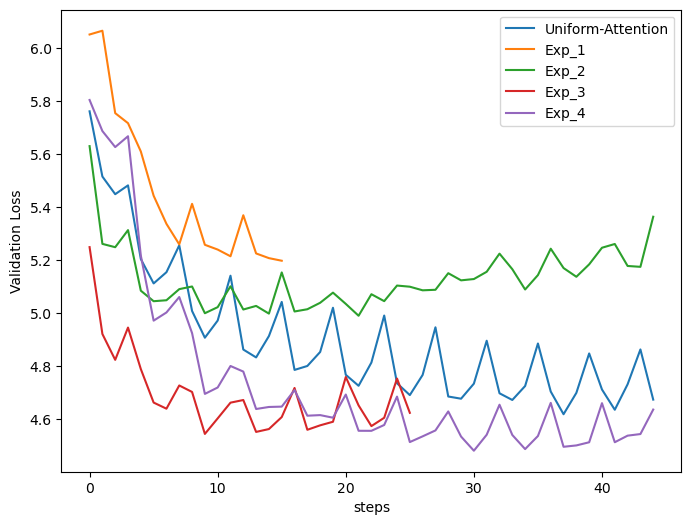

In [198]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
val_loss.iloc[:45,:].plot(ax=plt.gca())
plt.ylabel("Validation Loss")
plt.xlabel("step")
plt.show()

In [3]:
from seq2seq_attention.build_dataloaders import build_fields, get_datasets, build_vocab

src, trg = build_fields()
src_field, trg_field = build_fields()
train_set, val_set, test_set = get_datasets(train_path="./data/processed/train.csv", 
                                            val_path="./data/processed/val.csv", 
                                            test_path="./data/processed/test.csv", 
                                            src_field=src_field, 
                                            trg_field=trg_field)

max_vocab_size = 8000
min_freq = 2
build_vocab(src_field=src_field, trg_field=trg_field, train_set=train_set, min_freq=min_freq, max_vocab_size=max_vocab_size)

In [98]:
from seq2seq_attention.model import Seq2Seq_With_Attention
import torch 

lr = 1e-4
batch_size = 128
epochs = 15
enc_emb_dim = 256
hidden_dim_enc = 512
hidden_dim_dec = 512
num_layers_enc = 1
num_layers_dec = 1
emb_dim_trg = 256
device = "cpu"
teacher_forcing = 0.5
dropout=0


# Init from file
best_model_vals = torch.load("./experiments/Experiment-4/best_model_exp4.pt", map_location="cpu")
uniform_model_vals = torch.load("./experiments/Uniform-Attention/best_model.pt", map_location="cpu")

model = Seq2Seq_With_Attention(
        lr=lr,
        enc_vocab_size=len(src_field.vocab),
        vocab_size_trg=len(trg_field.vocab),
        enc_emb_dim=enc_emb_dim,
        hidden_dim_enc=hidden_dim_enc,
        hidden_dim_dec=hidden_dim_dec,
        padding_idx=src_field.vocab.stoi["<pad>"],
        num_layers_enc=num_layers_enc,
        num_layers_dec=num_layers_dec,
        emb_dim_trg=emb_dim_trg,
        trg_pad_idx=trg_field.vocab.stoi["<pad>"],
        device=device,
        seq_beginning_token_idx=trg_field.vocab.stoi[trg_field.init_token],
        dropout=dropout,
        train_attention=True
    )


uniform_model = Seq2Seq_With_Attention(
        lr=lr,
        enc_vocab_size=len(src_field.vocab),
        vocab_size_trg=len(trg_field.vocab),
        enc_emb_dim=enc_emb_dim,
        hidden_dim_enc=hidden_dim_enc,
        hidden_dim_dec=hidden_dim_dec,
        padding_idx=src_field.vocab.stoi["<pad>"],
        num_layers_enc=num_layers_enc,
        num_layers_dec=num_layers_dec,
        emb_dim_trg=emb_dim_trg,
        trg_pad_idx=trg_field.vocab.stoi["<pad>"],
        device=device,
        seq_beginning_token_idx=trg_field.vocab.stoi[trg_field.init_token],
        dropout=dropout,
        train_attention=False
    )

model.seq2seq.load_state_dict(best_model_vals["model_state_dict"])
uniform_model.seq2seq.load_state_dict(uniform_model_vals["model_state_dict"])

<All keys matched successfully>

### 3.1 Test Cross Entropy Loss for learned attention vs. uniform attention

In [32]:
from seq2seq_attention.evaluate import evaluate
from seq2seq_attention.build_dataloaders import build_bucket_iterator

# Dataloaders
test_loader = build_bucket_iterator(test_set, batch_size=256, device="cuda")

model.send_to_device()

# Test loss
eval_loss_exp4 = evaluate(model=model, eval_loader=test_loader)
eval_loss_uniform = evaluate(model=uniform_model, eval_loader=test_loader)

print(f"Test Loss with learned attention: {eval_loss_exp4}")
print(f"Test Loss with uniform attention: {eval_loss_uniform}")

### 3.2 BLEU-Score comparison

In [41]:
import pandas as pd

csv_reader_params = {"delimiter": ">", "skipinitialspace": True}
test_trans = pd.read_csv("./data/translation/test_all_trans.csv", **csv_reader_params)

In [42]:
from seq2seq_attention.bleu import get_bleu_dataset

get_bleu_dataset(dataset=test_trans, trg_field=trg_field, trans_col="trans_exp4", parallel=True)

17.74791538607161

In [43]:
get_bleu_dataset(dataset=test_trans, trg_field=trg_field, trans_col="trans_uniform", parallel=True)

12.08680725085549

In [45]:
# Further analysis

from seq2seq_attention.bleu import get_bleu_col

test_trans["bleu_exp4"] = get_bleu_col(dataset=test_trans, trg_field=trg_field, trans_col="trans_exp4")
test_trans["bleu_uniform"] = get_bleu_col(dataset=test_trans, trg_field=trg_field, trans_col="trans_uniform")

In [59]:
# Add sentence length column for src sentence
test_trans["src_len"] = test_trans.ger.apply(lambda sent: len(src_field.tokenize(sent)))
test_trans["trg_len"] = test_trans.eng.apply(lambda sent: len(trg_field.tokenize(sent)))

<Axes: ylabel='Frequency'>

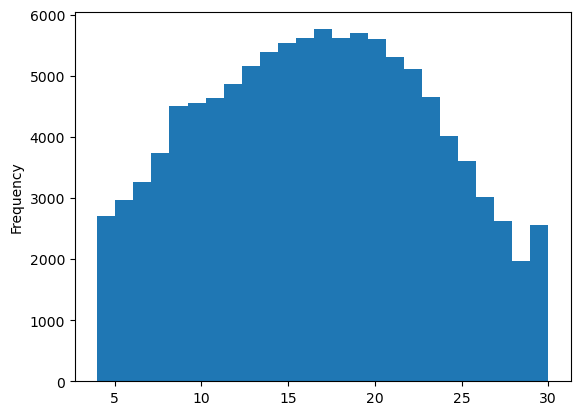

In [79]:
test_trans.src_len.plot(kind="hist", bins=25)

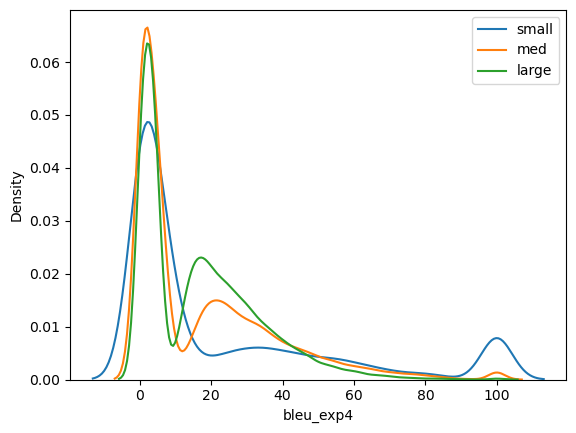

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data=test_trans[test_trans.src_len<10], x="bleu_exp4", label="small")
sns.kdeplot(data=test_trans[(test_trans.src_len>=10)&(test_trans.trg_len<20)], x="bleu_exp4", label="med")
sns.kdeplot(data=test_trans[test_trans.src_len>=20], x="bleu_exp4", label="large")
plt.legend()

In [150]:
# See sentences on which attention based system performs better
good = test_trans[test_trans.bleu_exp4>70]
good = good[good.bleu_exp4>good.bleu_uniform]
for i in range(10,15):
    print(good.ger.iloc[i])
    print(good.trans_exp4.iloc[i])
    print("")


Das wäre dann ein Kompromiss. 
that would then be a compromise .

Vielen Dank, Frau Kommissarin. 
thank you , commissioner .

(FI) Frau Präsidentin, Herr Kommissar! Zunächst möchte ich den Berichterstattern zu ihren hervorragenden und wichtigen Berichten zur Kohäsionspolitik gratulieren. 
( fi ) madam president , commissioner , i would like to congratulate the rapporteurs on their excellent and important reports on the cohesion policy .

Herr Präsident! Ich habe für dieses wichtige Dokument gestimmt. 
mr president , i voted in favour of this important document .

Unsere Meinung war, dass unsere Position vom Bürgerbeauftragten anerkannt werden würde. 
our opinion was that our position would be recognised by the ombudsman .



## 4. Visualize Attention

In [65]:
from seq2seq_attention.translate import translate_sentence_without

all_translations = []
for i, sent in enumerate(test.ger.values):
    trans = translate_sentence_without(sent,
                       seq2seq_model=model.seq2seq,
                       src_field=src_field,
                bos=src_field.init_token,
                eos=src_field.eos_token,
                eos_idx=src_field.vocab.stoi[src_field.eos_token],
                trg_field=trg_field,
                max_len=30,
            )
    all_translations.append(trans)
    
    if not i%10000:
        print(f"{i/len(test)*100:.2f}% done.")

0.00% done.
9.22% done.
18.45% done.
27.67% done.
36.89% done.
46.11% done.
55.34% done.
64.56% done.
73.78% done.
83.00% done.
92.23% done.


In [67]:
test["trans_uniform"] = all_translations

In [69]:
test.to_csv("./data/translation/all_trans.csv", sep=">", header=True, index=False)

In [100]:
from seq2seq_attention.visualize_attention import get_attention_frames
from seq2seq_attention.visualize_attention import plot_attention
import matplotlib.pyplot as plt
from seq2seq_attention.visualize_attention import get_attention_frames

examples = ["Dennoch ist das ein wichtiges Kriterium für die Europäische Union.",
            "Leider war das nicht der Fall.",
            "Vielen Dank für Ihre Antwort, Frau Kommissarin."]
trans, frames = get_attention_frames(sentences=examples, model=model, src_field=src_field, trg_field=trg_field)
trans

['however , this is an important criterion for the european union .',
 'unfortunately , that was not the case .',
 'thank you , commissioner , for your reply .']

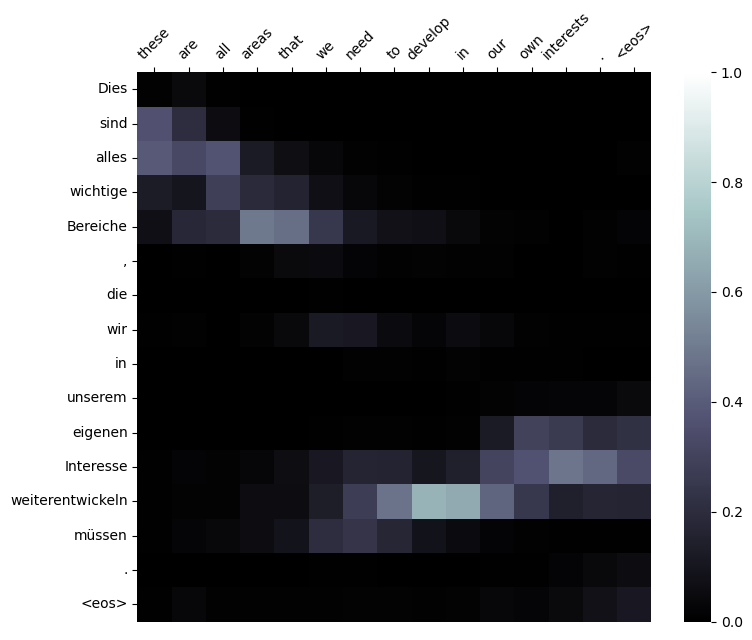

In [102]:
sent = "Dies sind alles wichtige Bereiche, die wir in unserem eigenen Interesse weiterentwickeln müssen. "
examples = [sent]
trans, frames = get_attention_frames(sentences=examples, model=model, src_field=src_field, trg_field=trg_field)
frame = frames[0]
plt.figure(figsize=(8,6.5))
plot = plot_attention(frame)
plt.tight_layout()
plt.savefig(fname="report/Sent1-attention", dpi=plt.gcf().dpi, bbox_inches='tight')

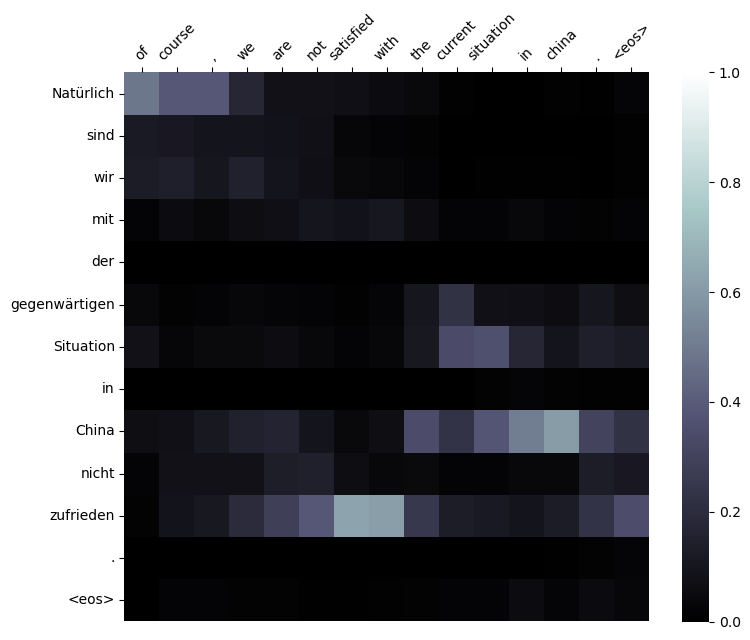

In [105]:
sent = "Natürlich sind wir mit der gegenwärtigen Situation in China nicht zufrieden. "
examples = [sent]
trans, frames = get_attention_frames(sentences=examples, model=model, src_field=src_field, trg_field=trg_field)
frame = frames[0]
plt.figure(figsize=(8,6.5))
plot = plot_attention(frame)
plt.tight_layout()

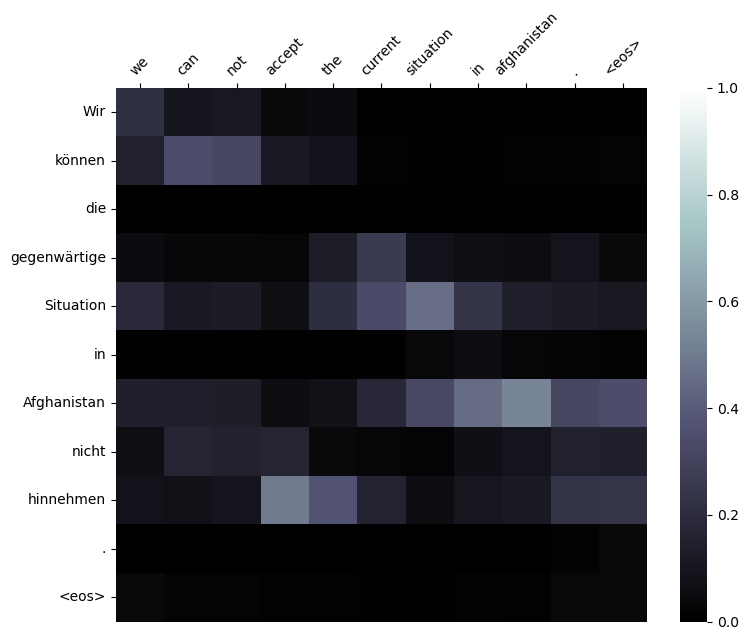

In [132]:
sent = "Wir können die gegenwärtige Situation in Afghanistan nicht hinnehmen. "
examples = [sent]
trans, frames = get_attention_frames(sentences=examples, model=model, src_field=src_field, trg_field=trg_field)
frame = frames[0]
plt.figure(figsize=(8,6.5))
plot = plot_attention(frame)
plt.tight_layout()

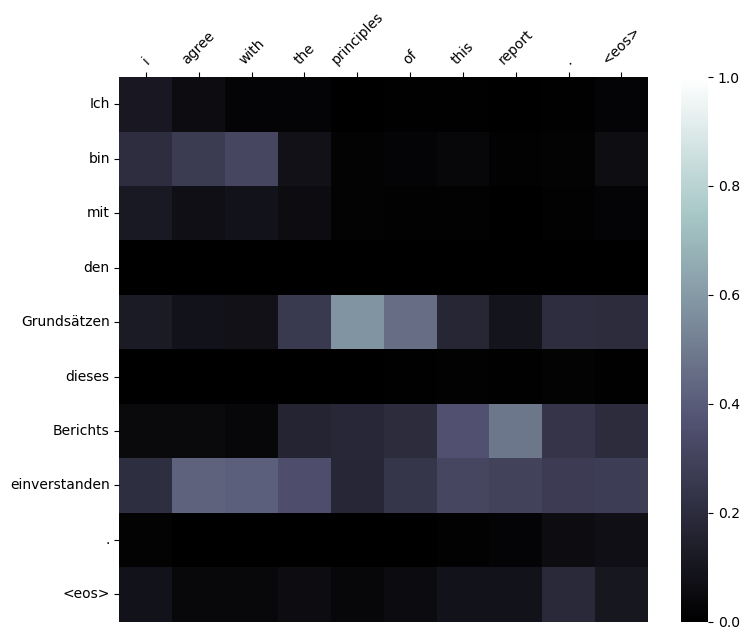

In [148]:
sent = "Ich bin mit den Grundsätzen dieses Berichts einverstanden. "
examples = [sent]
trans, frames = get_attention_frames(sentences=examples, model=model, src_field=src_field, trg_field=trg_field)
frame = frames[0]
plt.figure(figsize=(8,6.5))
plot = plot_attention(frame)
plt.tight_layout()